# Spectral resolution and subaperturing

In these notes, I'm looking at the effect that subaperturing has on the spectral resolving power that Lynx can achieve. Since most parts of the Lynx design are still in the air, there are a lot of assumptions in here, some of which might havea major influence on the result. I try to test the most important ones and call out the remaining uncertainties, but obviously this is a document in progress that must evolve with the evolving mission design.



In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from __future__ import print_function, division
import sys
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import marxs
from marxs import visualization

from marxs.source import PointSource, FixedPointing, JitterPointing

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from marxslynx import lynx

INFO: data files in version 0.0.dev8 (git hash 80ffb579cf256777f9e1af151b89cec639d3ea4c) [marxslynx.load_csv]
INFO: Loading data from /nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/marxslynx-0.0.dev8-py2.7.egg/marxslynx/data/gratings/efficiency.csv [marxslynx.load_csv]


In [4]:
import marxs.version
import marxslynx.version
print('MARXS version {} (commit hash: {} from {})'.format(marxs.version.version, marxs.version.githash, marxs.version.timestamp))
print('Lynx version {} (commit hash: {} from {})'.format(marxslynx.version.version, marxslynx.version.githash, marxslynx.version.timestamp))

MARXS version 1.1.dev579 (commit hash: e4533d88dd4019510ea51eed6d98f882c27b3f5c from 2017-06-26 10:43:11.132945)
Lynx version 0.0.dev8 (commit hash: 80ffb579cf256777f9e1af151b89cec639d3ea4c from 2017-07-20 13:43:01.797819)


In [5]:
n_photons = 1e5

mysource = PointSource(coords=SkyCoord(0., 0., unit='deg'),
                       energy=0.5,
                       flux=1.)
fixedpointing = FixedPointing(coords=SkyCoord(0., 0., unit='deg'))


photons = mysource.generate_photons(n_photons)
photons = fixedpointing(photons)
photons = lynx.default(photons)
photons = photons[np.isfinite(photons['order'])]

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/marxs-1.1.dev579-py2.7-linux-x86_64.egg/marxs/math/polarization.py:126: RuntimeWarning: invalid value encountered in divide
  s = s / np.linalg.norm(s, axis=1)[:, None]


In [53]:
facetpos = np.stack(lynx.gas.elem_pos)
#facetpos = np.stack([e.pos4d for e in lynx.gas.elements])
facetang = np.tan(facetpos[:, 1, 3]/ facetpos[:, 2, 3])
facetrad = np.sqrt(facetpos[:, 1, 3]**2 + facetpos[:, 2, 3]**2)

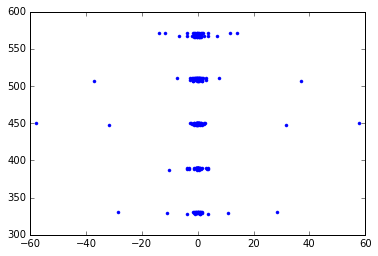

In [54]:
plt.plot(facetang, facetrad, '.')

## Zeroth order image

First, we look at a zeroth order image. That allows us to check that we got the mirror right.

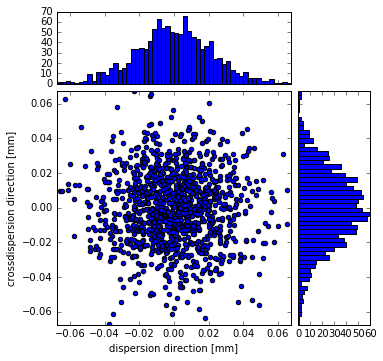

In [11]:
from matplotlib.ticker import NullFormatter

# the random data
ind = (photons['order'] == 0) & (np.abs(photons['proj_x'] < 10))
pgroups = photons[ind].group_by('order')
x = [p['proj_x'] for p in pgroups.groups]
y = [p['proj_y'] for p in pgroups.groups]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(5, 5))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.0025
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
histx = axHistx.hist(x, bins=bins, stacked=True)
histy = axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.set_xlabel('dispersion direction [mm]')
axScatter.set_ylabel('crossdispersion direction [mm]')

In [12]:
len(x)

1

In [13]:
def fwhm(hist):
    '''Simple estimate of FWHM from histogram
    
    This just takes the value of the largest bin to be the max value and then
    finds the number of bins that are  > half that value.
    Multiplying the number with the bin width (assuming equal bins)
    gives an estiamte of the FWHM.
    '''
    maxval = np.max(hist[0])
    halfmax = maxval / 2
    ind = hist[0] > halfmax
    return ind.sum() * np.mean(np.diff(hist[1]))

In [14]:
print('Estimate for FWHM in x and y [in mm]:', fwhm(histx), fwhm(histy))
print('0.5 arcsec correspond to {} mm.'.format(np.deg2rad(0.5/3600.) * 9000.))

Estimate for FWHM in x and y [in mm]: 0.0475 0.0475
0.5 arcsec correspond to 0.0218166156499 mm.


In [15]:
pgroups = photons.group_by('order')

In [16]:
pgroups.groups

<TableGroups indices=[    0    14    31  1011  6761 36481 53536 56943 57144 57731 58827 59899
 60306 61479]>

In [17]:
len(photons)

61479